In [1]:
!pip install q numpy==1.17

In [0]:
import re

import os
from os import listdir
from os.path import isfile, join

import torch
from torch.utils.data import Dataset

import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import numpy as np

from PIL import Image

import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1p1BWofDJOKXqCtO0JPT5VyuIPOsuxOuj' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1p1BWofDJOKXqCtO0JPT5VyuIPOsuxOuj" -O openlogo.tar && rm -rf /tmp/cookies.txt
!tar -xvf openlogo.tar

images_folder = "openlogo/JPEGImages"
annotations_folder = "openlogo/Annotations"

Streaming output truncated to the last 5000 lines.
openlogo/JPEGImages/hondaimg000205.jpg
openlogo/Annotations/apeimg000015.xml
openlogo/Annotations/siemens3.xml
openlogo/JPEGImages/logos32plus_003856.jpg
openlogo/JPEGImages/chanel41.jpg
openlogo/JPEGImages/Belgalogos_07582934.jpg
openlogo/JPEGImages/61839900.jpg
openlogo/Annotations/kraftimg000003.xml
openlogo/JPEGImages/logos32plus_000801.jpg
openlogo/Annotations/logos32plus_003692.xml
openlogo/JPEGImages/essoimg000006.jpg
openlogo/JPEGImages/logos32plus_001952.jpg
openlogo/Annotations/batman5.xml
openlogo/JPEGImages/Hisense_sportslogo_65.jpg
openlogo/Annotations/logos32plus_000073.xml
openlogo/JPEGImages/flickrlogo27_3778060828.jpg
openlogo/Annotations/boschimg000151.xml
openlogo/JPEGImages/aralimg000145.jpg
openlogo/Annotations/prada48.xml
openlogo/JPEGImages/fritolaysimg000043.jpg
openlogo/Annotations/logos32plus_000459.xml
openlogo/Annotations/logos32plus_004264.xml
openlogo/JPEGImages/boeingimg000044.jpg
openlogo/JPEGImages/logo

In [4]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 7291 (delta 0), reused 2 (delta 0), pack-reused 7289
Receiving objects: 100% (7291/7291), 9.93 MiB | 2.76 MiB/s, done.
Resolving deltas: 100% (4932/4932), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
device = torch.device('cuda:0')

In [0]:
image_pattern = re.compile(r'^(?P<key>\w+)\.jpg$')
annotation_pattern = re.compile(r'^(?P<key>\w+)\.xml$')

class LogoDetectionDataset(Dataset):
  
  def __init__(self, image_folder, annotation_folder, transform=None):
    self.image_folder = image_folder
    self.annotation_folder = annotation_folder
    self.transform = transform
    self.image_names = self.__get_file_names__(image_folder, image_pattern)
    self.annotation_names = self.__get_file_names__(annotation_folder, annotation_pattern)

    self.keys = sorted(list(set(self.image_names.keys()) & set(self.annotation_names.keys())))
  
  def __len__(self):
    return len(self.keys)

  def __getitem__(self, index): 
    key = self.keys[index]

    image_name = self.image_names[key]
    annotation_name = self.annotation_names[key]

    image_path = os.path.join(self.image_folder, image_name)
    annotation_path = os.path.join(self.annotation_folder, annotation_name)

    img = Image.open(image_path).convert('RGB')
    target = self.__get_target__(annotation_path, index)

    if self.transform:
      img, target = self.transform(img, target)

    return img, target

  def __get_target__(self, annotation_path, index):
    target = {}
    boxes = []
    root = ET.parse(annotation_path).getroot()
    for bndbox in root.findall('object/bndbox'):
      xmin = int(bndbox[0].text)
      ymin = int(bndbox[1].text)
      xmax = int(bndbox[2].text)
      ymax = int(bndbox[3].text)
      boxes.append((xmin, ymin, xmax, ymax))

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    num_objs = len(boxes)
    labels = torch.ones((num_objs), dtype=torch.int64)
    img_id = torch.tensor([index])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = img_id
    target['area'] = area
    target['iscrowd'] = iscrowd
    return target

  def __get_file_names__(self, folder, file_name_pattern):
    file_names = {}
    for f in listdir(folder):
      match = file_name_pattern.match(f)
      if not match:
        continue
      
      num = match.group('key')
      if num == '':
        continue
      
      file_names[num] = f

    return file_names

In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms

tfs = transforms.Compose([
                          transforms.ToTensor(),                       
                       ])

num_classes = 2
batch_size = 4

dataset = LogoDetectionDataset(images_folder, annotations_folder, transform=tfs)
orig_dataset = LogoDetectionDataset(images_folder, annotations_folder)

validation_size = .3

data_size = len(dataset)
split = int(np.floor(validation_size * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

val_indices, train_indices = indices[:split], indices[split:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, collate_fn=utils.collate_fn)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, 
                                         sampler=val_sampler, collate_fn=utils.collate_fn)

In [0]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005,
#                            momentum=0.9, weight_decay=0.0005)

#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                               step_size=3,
#                                               gamma=0.1)

optimizer = torch.optim.Adam(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [0]:
model = torch.load("drive/My Drive/save/save-complete")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [0]:
last_saved_epoch = 0
num_epochs = 5

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
  lr_scheduler.step()
  torch.save(model, "drive/My Drive/save/save-adam-" + str(last_saved_epoch + epoch))
  #evaluate(model, val_loader, device=device)

Epoch: [0]  [   0/4683]  eta: 2:13:56  lr: 0.000010  loss: 0.8903 (0.8903)  loss_classifier: 0.6883 (0.6883)  loss_box_reg: 0.0853 (0.0853)  loss_objectness: 0.1017 (0.1017)  loss_rpn_box_reg: 0.0150 (0.0150)  time: 1.7162  data: 0.0567  max mem: 8745
Epoch: [0]  [  10/4683]  eta: 1:45:41  lr: 0.000060  loss: 0.5517 (0.5730)  loss_classifier: 0.2179 (0.3446)  loss_box_reg: 0.0853 (0.0817)  loss_objectness: 0.0954 (0.1297)  loss_rpn_box_reg: 0.0133 (0.0170)  time: 1.3571  data: 0.0585  max mem: 8745
Epoch: [0]  [  20/4683]  eta: 1:52:23  lr: 0.000110  loss: 0.3384 (0.4354)  loss_classifier: 0.1422 (0.2524)  loss_box_reg: 0.0662 (0.0829)  loss_objectness: 0.0305 (0.0830)  loss_rpn_box_reg: 0.0133 (0.0172)  time: 1.4327  data: 0.0764  max mem: 8745
Epoch: [0]  [  30/4683]  eta: 1:55:47  lr: 0.000160  loss: 0.2457 (0.3983)  loss_classifier: 0.1341 (0.2232)  loss_box_reg: 0.0835 (0.0940)  loss_objectness: 0.0227 (0.0624)  loss_rpn_box_reg: 0.0155 (0.0188)  time: 1.5678  data: 0.0894  max me

In [0]:
torch.save(model, "drive/My Drive/save/save-adam-complete")


In [9]:
evaluate(model, val_loader, device=device)

creating index...
index created!
Test:  [   0/8026]  eta: 1:31:34  model_time: 0.6361 (0.6361)  evaluator_time: 0.0147 (0.0147)  time: 0.6846  data: 0.0264  max mem: 556
Test:  [ 100/8026]  eta: 0:22:57  model_time: 0.1399 (0.1439)  evaluator_time: 0.0081 (0.0080)  time: 0.1681  data: 0.0172  max mem: 719
Test:  [ 200/8026]  eta: 0:22:50  model_time: 0.1470 (0.1437)  evaluator_time: 0.0072 (0.0085)  time: 0.1750  data: 0.0190  max mem: 719
Test:  [ 300/8026]  eta: 0:22:39  model_time: 0.1403 (0.1427)  evaluator_time: 0.0069 (0.0082)  time: 0.1686  data: 0.0192  max mem: 1044
Test:  [ 400/8026]  eta: 0:22:09  model_time: 0.1474 (0.1424)  evaluator_time: 0.0074 (0.0083)  time: 0.1793  data: 0.0210  max mem: 1044
Test:  [ 500/8026]  eta: 0:21:54  model_time: 0.1390 (0.1426)  evaluator_time: 0.0072 (0.0082)  time: 0.1869  data: 0.0388  max mem: 1044
Test:  [ 600/8026]  eta: 0:21:36  model_time: 0.1394 (0.1426)  evaluator_time: 0.0073 (0.0082)  time: 0.1744  data: 0.0248  max mem: 1044
Test

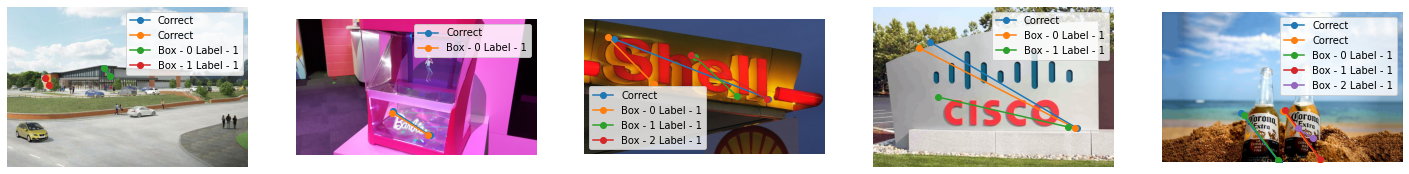

In [0]:
score_filter = 0.5

model.eval()
count = 5
plt.figure(figsize=(count * 5,5))
for i_step, (images, targets) in enumerate(val_loader):
  if i_step == count:
    break
    
  val_image = list(image.to(device) for image in images)
  prediction = model(val_image)[0]

  image_id = int(targets[0]['image_id'])
  image, target = orig_dataset[image_id]

  boxes = target['boxes']
  predict_boxes = prediction['boxes']
  predict_labels = prediction['labels']
  predict_scores = prediction['scores']

  plt.subplot(1, count, i_step + 1)
  plt.imshow(image)

  for box in boxes:
    x = [box[0], box[2]]
    y = [box[1], box[3]]
    plt.plot(x, y, marker = 'o', label='Correct')
  for i, box in enumerate(predict_boxes):
    if predict_scores[i] < score_filter:
      continue
    x = [box[0], box[2]]
    y = [box[1], box[3]]
    predict_label = int(predict_labels[i])
    view_label = 'Box - %d Label - %d' % (i, predict_label)
    plt.plot(x, y, marker = 'o', label=view_label)

  plt.grid(False)
  plt.axis('off')
  plt.legend()  